#  <center> Speech Emotion Recognition <center>

### I am going to build a speech emotion detection classifier.
### But first we need to learn about what is speech recognition (SER) and why are we building this project? Well, few of the reasons are-

#### First, lets define SER i.e. Speech Emotion Recognition.
* Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

#### Why we need it?

1. Emotion recognition is the part of speech recognition which is gaining more popularity and need for it increases enormously. Although there are methods to recognize emotion using machine learning techniques, this project attempts to use deep learning to recognize the emotions from data.

2. SER(Speech Emotion Recognition) is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services

3. It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

#### Datasets used in this project

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto emotional speech set (Tess)

# Importing Libraries

In [1]:
! apt-get update
! apt-get install -y libsndfile-dev

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5391 B]
Get:3 http://packages.cloud.google.com/apt cloud-sdk-bionic InRelease [6786 B]
Get:4 http://packages.cloud.google.com/apt cloud-sdk InRelease [6751 B]
Get:5 http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1581 B]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Err:2 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY FEEA9169307EA071 NO_PUBKEY 8B57C5C2836F4BEB
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2830 kB]
Ign:9 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security/multivers

In [2]:
import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Using TensorFlow backend.


## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [4]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
Berlin="/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [5]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head(10)

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
5      fear  /kaggle/input/ravdess-emotional-speech-audio/a...
6       sad  /kaggle/input/ravdess-emotional-speech-audio/a...
7   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
8   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
9     happy  /kaggle/input/ravdess-emotional-speech-audio/a...

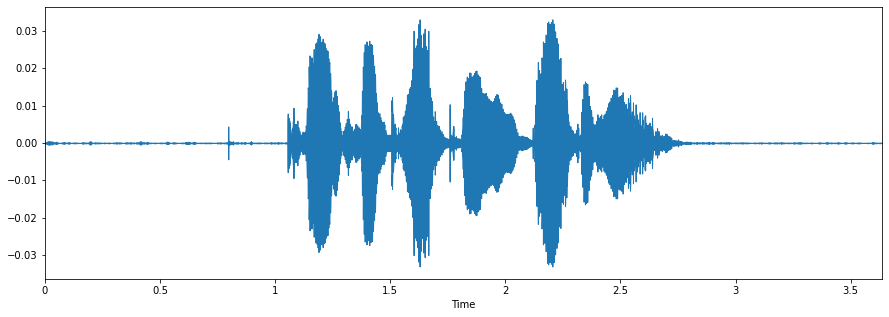

In [6]:
# use the well known Librosa library for this task 
#Ravdess
fname = '../input/ravdess-emotional-speech-audio/Actor_08/03-01-01-01-01-02-08.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
Audio(fname)

## <center>2. Crema DataFrame</center>

In [7]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  disgust  /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1    happy  /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2    happy  /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3  disgust  /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4  disgust  /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav

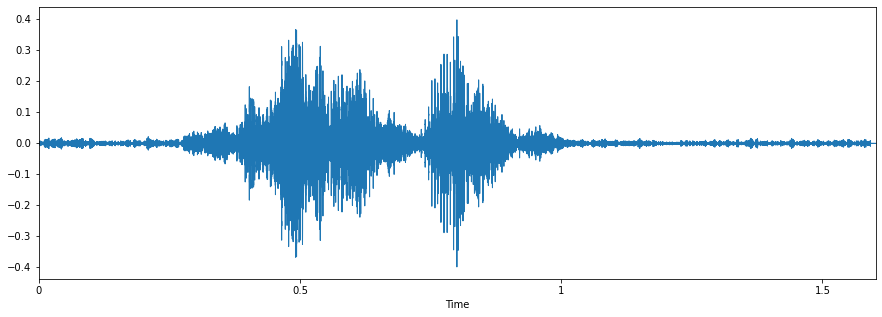

In [8]:
# use the well known Librosa library for this task 
#Crema
fname = Crema+'1001_IEO_FEA_MD.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
Audio(fname)

##  <center> 3. TESS dataset <center>

In [9]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0     fear  /kaggle/input/toronto-emotional-speech-set-tes...
1     fear  /kaggle/input/toronto-emotional-speech-set-tes...
2     fear  /kaggle/input/toronto-emotional-speech-set-tes...
3     fear  /kaggle/input/toronto-emotional-speech-set-tes...
4     fear  /kaggle/input/toronto-emotional-speech-set-tes...

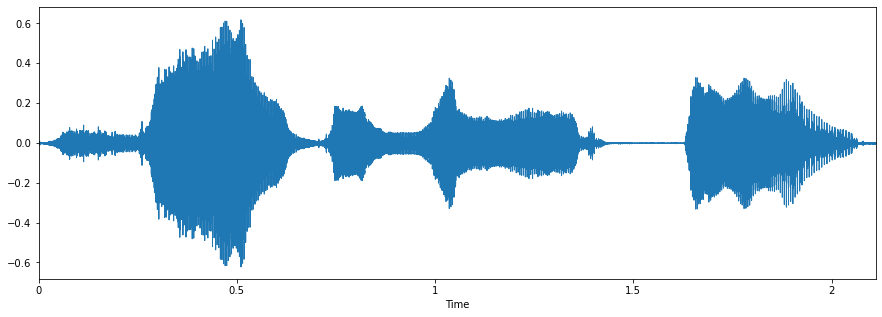

In [10]:
# use the well known Librosa library for this task 
#Crema
fname = '../input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_bar_angry.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
Audio(fname)

##  <center> 4. SAv dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [11]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
1     fear  /kaggle/input/surrey-audiovisual-expressed-emo...
2    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
3  disgust  /kaggle/input/surrey-audiovisual-expressed-emo...
4    angry  /kaggle/input/surrey-audiovisual-expressed-emo...

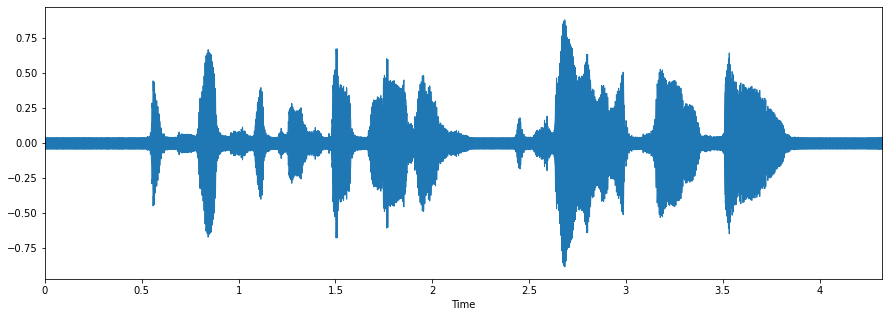

In [12]:
# use the well known Librosa library for this task 
fname = Savee + 'DC_f11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
Audio(fname)

##  <center> 5. Berlin dataset <center>
The audio files in this dataset are named in such a way that the prefix letters (in Germany) describes the emotion classes as follows:

* 'W' = 'anger'
* 'E' = 'disgust'
* 'A' = 'fear'
* 'F' = 'happiness'
* 'N' = 'neutral'
* 'T' = 'sadness'
* 'L' = 'boredom'
   'L' and 'T' will classicfied in sad emotion.
    this dataset doesn't have the suprise emotion

In [13]:
berlin_directory_list = os.listdir(Berlin)

file_emotion = []
file_path = []

for file in berlin_directory_list:
    file_path.append(Berlin + file)
    
    ele = file[5]
    if ele=='W':
        file_emotion.append('angry')
    elif ele=='E':
        file_emotion.append('disgust')
    elif ele=='A':
        file_emotion.append('fear')
    elif ele=='F':
        file_emotion.append('happy')
    elif ele=='N':
        file_emotion.append('neutral')
    elif ele=='L'or ele=='T':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Berlin_df = pd.concat([emotion_df, path_df], axis=1)
Berlin_df.head(10)

Emotions                                               Path
0    happy  /kaggle/input/berlin-database-of-emotional-spe...
1    happy  /kaggle/input/berlin-database-of-emotional-spe...
2    angry  /kaggle/input/berlin-database-of-emotional-spe...
3    angry  /kaggle/input/berlin-database-of-emotional-spe...
4    angry  /kaggle/input/berlin-database-of-emotional-spe...
5     fear  /kaggle/input/berlin-database-of-emotional-spe...
6    angry  /kaggle/input/berlin-database-of-emotional-spe...
7      sad  /kaggle/input/berlin-database-of-emotional-spe...
8    angry  /kaggle/input/berlin-database-of-emotional-spe...
9    angry  /kaggle/input/berlin-database-of-emotional-spe...

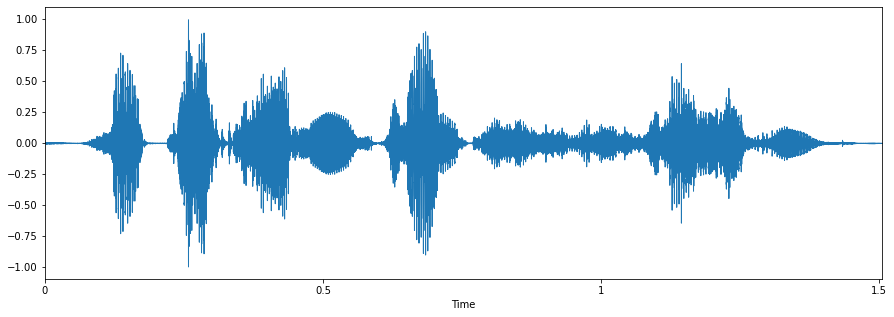

In [14]:
# use the well known Librosa library for this task 
fname = Berlin + '03a04Ad.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
Audio(fname)

In [15]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Tess_df, Savee_df, Crema_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

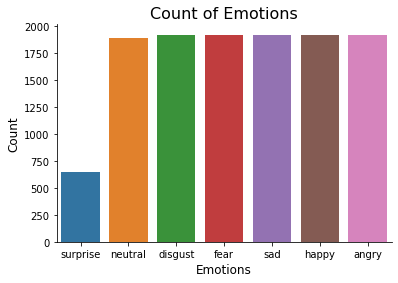

In [16]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [17]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

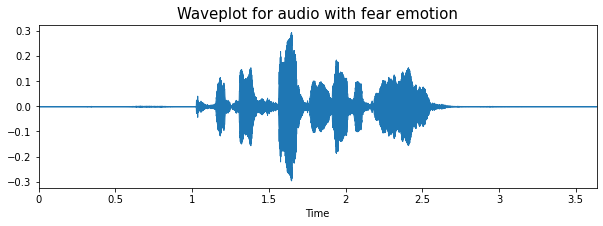

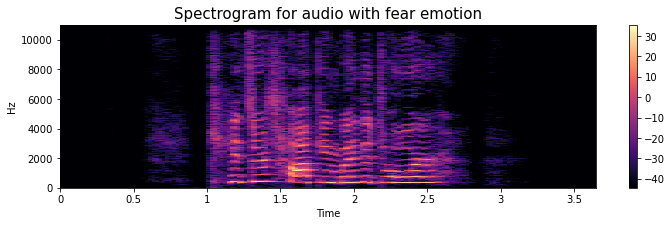

In [18]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

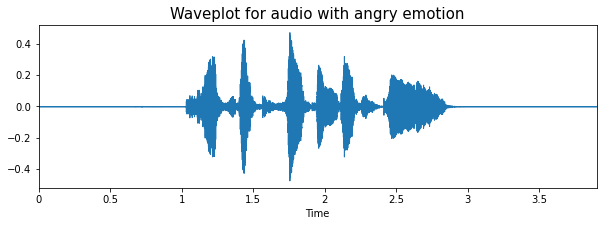

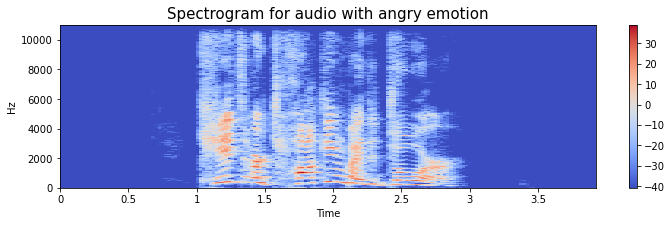

In [19]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

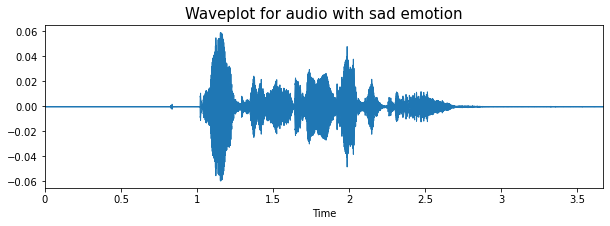

22050


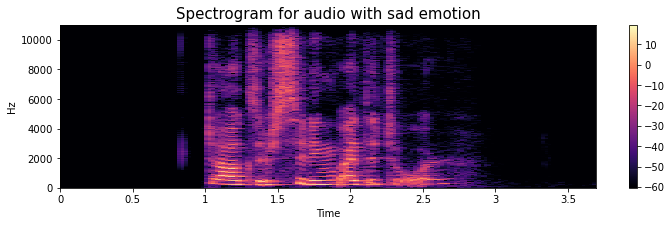

In [20]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

print(sampling_rate)

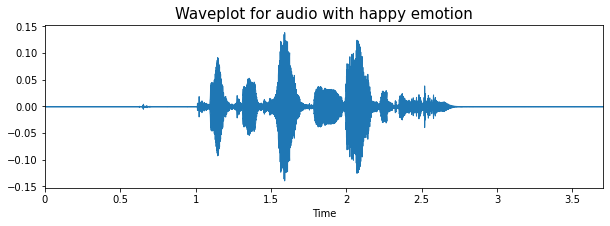

22050


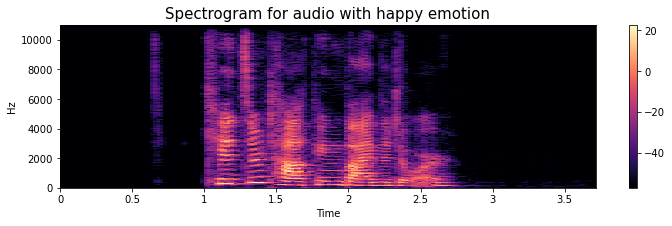

In [21]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)
print(sampling_rate)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [22]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

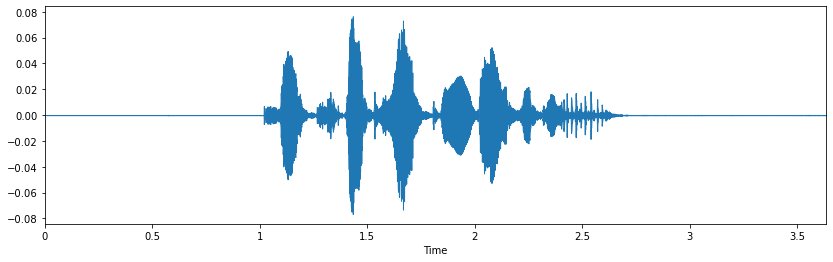

In [23]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

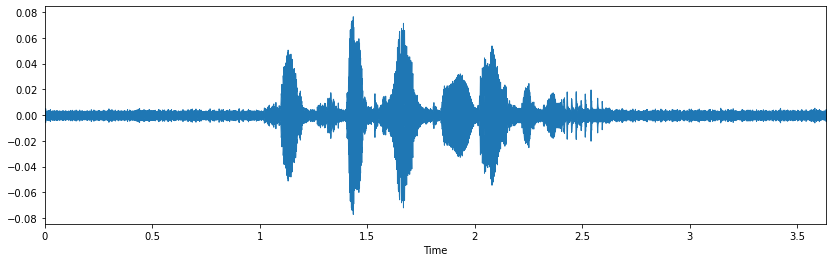

In [24]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

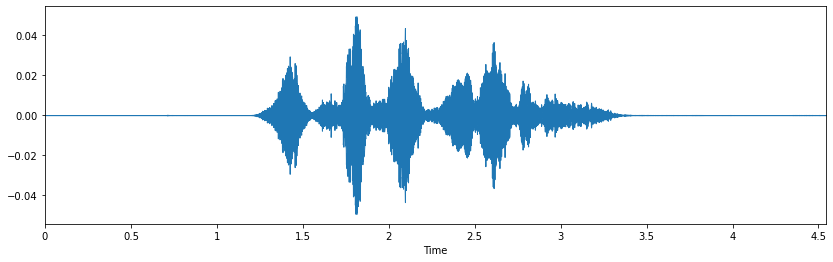

In [25]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

22050

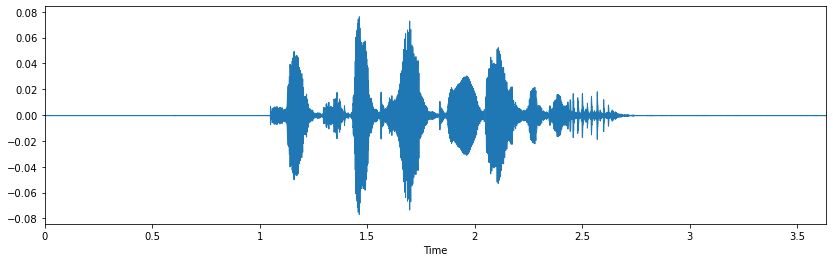

In [26]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)
sample_rate

#### 5. Pitch

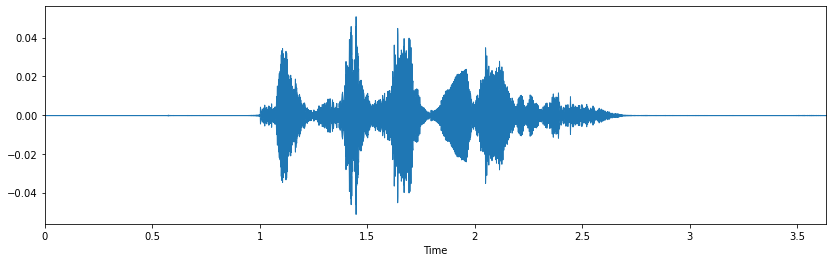

In [27]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [28]:
n_fft = 2048
hop_length = 512

In [29]:
# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [30]:
# def extract_features(data):
#     # ZCR
#     result = np.array([])
#     zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
#     result=np.hstack((result, zcr)) # stacking horizontally

#     # Chroma_stft
# #     stft = np.abs(librosa.stft(data))
# #     chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
# #     result = np.hstack((result, chroma_stft)) # stacking horizontally

#     # MFCC
#     mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
#     result = np.hstack((result, mfcc)) # stacking horizontally

#     # Root Mean Square Value
#     rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
#     result = np.hstack((result, rms)) # stacking horizontally

#     # MelSpectogram
# #     mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
# #     result = np.hstack((result, mel)) # stacking horizontally
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        # np.mean(energy(data, frame_length, hop_length),axis=0),
                        # np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
                        # mel_spc(data, sr, frame_length, hop_length, flatten=True)
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result
    
#     return result

In [31]:


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with pitching
    data_pitch = pitch(data, sample_rate)
    res3 = extract_features(data_pitch,sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    # data with pitching and white_noise
    new_data = pitch(data, sample_rate)
    data_noise_pitch = noise(new_data)
    res4 = extract_features(data_noise_pitch,sample_rate)
    result = np.vstack((result, res4)) # stacking vertically
    
    return result

In [32]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [33]:
len(X), len(Y), data_path.Path.shape


(48648, 48648, (12162,))

In [34]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head(20)

0         1         2         3         4         5         6  \
0   0.342285  0.479492  0.573730  0.458008  0.376465  0.301758  0.269043   
1   0.254883  0.381348  0.507324  0.510254  0.499512  0.490723  0.501465   
2   0.303711  0.430176  0.531250  0.461914  0.379883  0.319336  0.280273   
3   0.268555  0.389160  0.499023  0.451172  0.388672  0.333008  0.288086   
4   0.420898  0.631348  0.833008  0.837891  0.831055  0.821777  0.819824   
5   0.249512  0.367676  0.490234  0.497070  0.490723  0.505371  0.509766   
6   0.285645  0.410645  0.544434  0.490723  0.463379  0.437988  0.402832   
7   0.233398  0.355957  0.478516  0.504395  0.502930  0.504883  0.506836   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.049805  0.121094   
9   0.243652  0.369141  0.491699  0.487793  0.495117  0.494141  0.496094   
10  0.000000  0.000000  0.000000  0.145020  0.257324  0.375977  0.506348   
11  0.239746  0.362305  0.492188  0.508301  0.506836  0.508301  0.503906   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.260742  0.395996  0.514648  0.502441  0.506348  0.499512  0.505859   
14  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.253906  0.376953  0.500977  0.499023  0.499512  0.508301  0.508301   
16  0.354004  0.478516  0.639648  0.672852  0.707520  0.735840  0.752930   
17  0.251465  0.376465  0.497559  0.495605  0.490234  0.495117  0.497559   
18  0.248535  0.356445  0.491211  0.511719  0.523438  0.524414  0.504395   
19  0.263184  0.386719  0.507324  0.506348  0.495117  0.497070  0.496582   

           7         8         9  ...       2367       2368       2369  \
0   0.256348  0.252441  0.252930  ...  -1.800944  -1.947110  -1.746312   
1   0.503906  0.506836  0.516113  ...  -1.181416   4.366098   5.315839   
2   0.266113  0.261230  0.261230  ...   1.687637   2.040603   2.416945   
3   0.271973  0.264160  0.273926  ...   4.349244   2.051482  -0.973182   
4   0.810059  0.804688  0.627930  ...   2.861256   2.993450   2.379827   
5   0.514648  0.506348  0.496094  ...  -0.575203  -0.954383  -1.671313   
6   0.381836  0.391602  0.384766  ...   8.848892   9.139691   7.758842   
7   0.495605  0.507324  0.507812  ...   3.527547  -4.566996   0.750719   
8   0.121094  0.168945  0.277344  ...   5.207092 -24.368179  23.136841   
9   0.488281  0.484863  0.482910  ... -10.462618  -8.590216   3.306631   
10  0.495117  0.504883  0.506836  ...   1.326581 -24.008339  12.614294   
11  0.479492  0.485352  0.481934  ...  -9.216599  -6.070797   3.416563   
12  0.000000  0.000000  0.000000  ...   0.943145  -0.231550  -1.535729   
13  0.522949  0.515137  0.511230  ...   0.941909  -0.243425  -1.551512   
14  0.000000  0.087402  0.225586  ...   0.461238   0.366691   0.244801   
15  0.507324  0.508789  0.506348  ...   1.077543  -0.657454  -2.308617   
16  0.688965  0.637207  0.684570  ...   3.191881   3.446969   3.624839   
17  0.498535  0.498535  0.496094  ...  -2.307394  -4.026510  -2.174540   
18  0.468750  0.452637  0.499512  ...   0.546565   0.254148   0.095168   
19  0.495117  0.505859  0.499512  ...   7.087781   5.017251  -3.673748   

         2370       2371       2372      2373      2374      2375    labels  
0   -1.296943  -0.702259  -0.045278  0.624514  1.286767  1.931510  surprise  
1   -1.291671   3.748514   4.587148  2.200898  1.764357 -0.578409  surprise  
2    2.743222   2.960053   3.031116  2.948024  2.730061  2.419729  surprise  
3    6.857495   5.611474   4.147239  4.837396  3.910537  1.236526  surprise  
4    1.030240  -0.787677  -2.658594 -4.171967 -5.034144 -5.102701   neutral  
5   -0.791840  -0.501038  -1.515965  2.488162  2.982862  4.178791   neutral  
6    4.971623   1.409157  -2.224360 -5.296460 -7.229548 -7.525167   neutral  
7    0.977392  -3.009284  -2.131462 -7.135162 -7.427774  2.896345   neutral  
8  -17.047810  -2.212386 -14.705015 -2.622180 -8.794046  2.607786   disgust  
9   -0.864412  -7.075448 -11.680555 -8.418067 -2.736701  0.785859   disgust  
1

In [35]:
Features = pd.read_csv('features.csv')
print(Features.shape)

(48648, 2377)


In [36]:
# Fill NaN with 0
Features = Features.fillna(0)
print(Features.isna().any())
Features.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(48648, 2377)

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [37]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [38]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

encoder.categories_

[array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
       dtype=object)]

In [39]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [40]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, test_size=0.1, shuffle=True)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

((35026, 2376),
 (9730, 2376),
 (3892, 2376),
 (35026, 2376),
 (9730, 2376),
 (3892, 2376))

In [41]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((35026, 2376), (35026, 7), (9730, 2376), (9730, 7))

In [42]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((35026, 2376, 1),
 (35026, 7),
 (9730, 2376, 1),
 (9730, 7),
 (3892, 2376, 1),
 (3892, 7))

## Modelling

In [43]:
# model=Sequential()

# model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(Dropout(0.2))

# model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Flatten())
# model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(7, activation='softmax'))
# model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

# model.summary()

In [44]:
model=Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

#just add new layers
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))


model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(7, activation="softmax"))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2376, 512)         3072      
_________________________________________________________________
batch_normalization_1 (Batch (None, 2376, 512)         2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1188, 512)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1188, 512)         1311232   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1188, 512)         2048      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 594, 512)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 594, 256)         

In [45]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0.05,
    patience=20,
    verbose=1,
    restore_best_weights=True
)


In [46]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
callbacks=[early_stopping,
    rlrp
]


In [47]:
earlystopping2 = EarlyStopping(monitor ="val_acc",min_delta=0.05,
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks2=[earlystopping2,learning_rate_reduction]

In [48]:
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks2)

Train on 35026 samples, validate on 3892 samples
Epoch 1/100
35026/35026 [==============================] - 102s 3ms/step - loss: 1.4891 - accuracy: 0.4269 - val_loss: 1.4626 - val_accuracy: 0.4293
Epoch 2/100
35026/35026 [==============================] - 97s 3ms/step - loss: 1.2105 - accuracy: 0.5297 - val_loss: 1.2540 - val_accuracy: 0.5141
Epoch 3/100
35026/35026 [==============================] - 97s 3ms/step - loss: 1.1174 - accuracy: 0.5676 - val_loss: 1.2863 - val_accuracy: 0.5039
Epoch 4/100
35026/35026 [==============================] - 97s 3ms/step - loss: 1.0655 - accuracy: 0.5888 - val_loss: 1.1061 - val_accuracy: 0.5776
Epoch 5/100
35026/35026 [==============================] - 97s 3ms/step - loss: 1.0144 - accuracy: 0.6111 - val_loss: 1.0411 - val_accuracy: 0.6038
Epoch 6/100
35026/35026 [==============================] - 97s 3ms/step - loss: 0.9732 - accuracy: 0.6277 - val_loss: 0.9625 - val_accuracy: 0.6339
Epoch 7/100
35026/35026 [==============================] - 97s

In [49]:
# Save model and weights
model_name = 'Emotion_Model_no_gender.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /kaggle/working/saved_models/Emotion_Model_no_gender.h5 


In [50]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
print(early_stopping.stopped_epoch)

9730/9730 [==============================] - 10s 1ms/step
Accuracy of our model on test data :  88.20143938064575 %
0


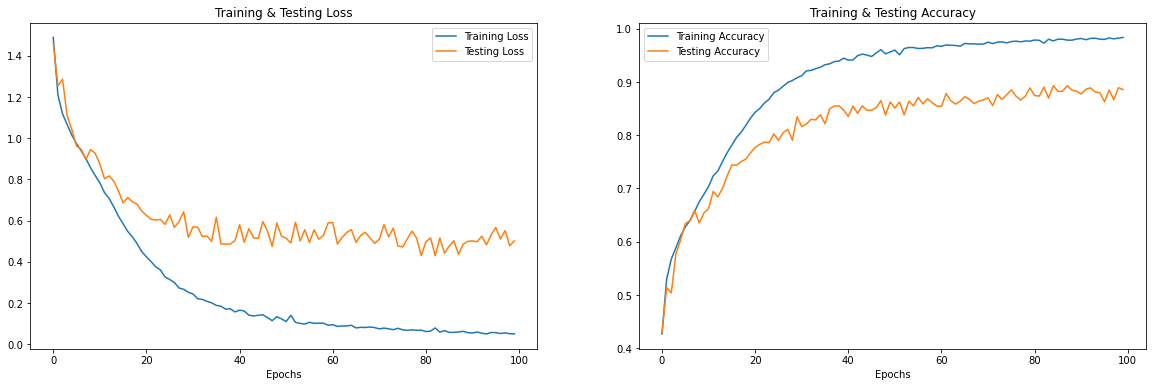

In [51]:
# epochs = [i for i in range(early_stopping.stopped_epoch+1) ]
epochs = [i for i in range(100) ]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [52]:
# predicting on test data.
pred_test = model.predict(x_test)
x_test.shape
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [53]:

pred_test=model.predict(x_test)

In [54]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

Predicted Labels Actual Labels
0          surprise         angry
1               sad           sad
2             happy         happy
3              fear           sad
4             happy         happy
5               sad           sad
6             angry          fear
7          surprise      surprise
8             angry         angry
9           neutral       neutral
10            angry         angry
11          disgust          fear
12             fear          fear
13             fear          fear
14          disgust       disgust
15              sad           sad
16          neutral       neutral
17              sad           sad
18              sad       disgust
19             fear          fear

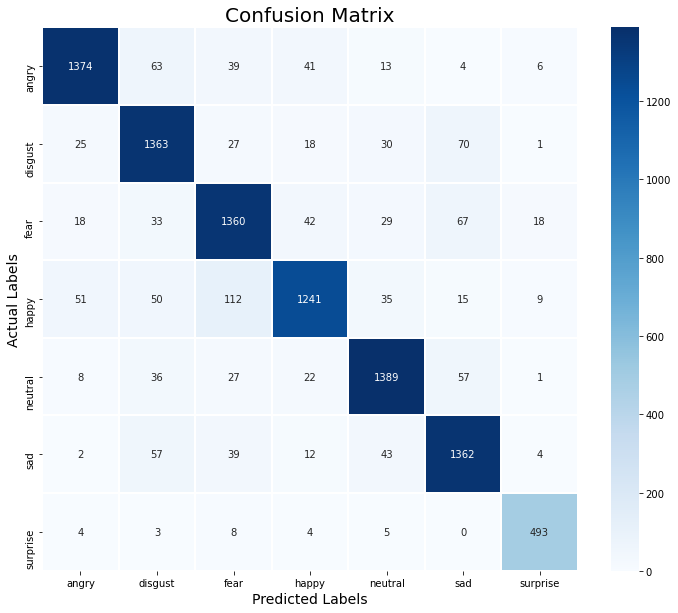

In [55]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.93      0.89      0.91      1540
     disgust       0.85      0.89      0.87      1534
        fear       0.84      0.87      0.86      1567
       happy       0.90      0.82      0.86      1513
     neutral       0.90      0.90      0.90      1540
         sad       0.86      0.90      0.88      1519
    surprise       0.93      0.95      0.94       517

    accuracy                           0.88      9730
   macro avg       0.89      0.89      0.89      9730
weighted avg       0.88      0.88      0.88      9730



In [57]:
# happy_path="../input/test-sound/test1_happy.wav"
# data, sample_rate = librosa.load(happy_path, duration=2.5, offset=0.6)
# print(sample_rate)
# result3=get_features(happy_path)
# print("Data : ")

# result3=np.expand_dims(result3,axis=2)
# result3.shape




# predict3=model.predict(result3)
# print(predict3)
# predict3=encoder.inverse_transform(predict3)
# print(predict3)

In [58]:
# happy_path="../input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav"
# data, sample_rate = librosa.load(happy_path, duration=2.5, offset=0.6)
# print(sample_rate)
# result3=get_features(happy_path)
# print("Data : ")

# result3=np.expand_dims(result3,axis=2)
# result3.shape




# predict3=model.predict(result3)
# print(predict3)
# predict3=encoder.inverse_transform(predict3)
# print(predict3)

- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.

### This is all i wanna do in this project. Hope you guyz like this. 
### If you like the kernel make sure to upvote it please :-)